In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import numpy as np 
import pandas as pd

In [3]:
import pyBigWig
from tqdm import tqdm
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import kde
from scipy import stats

In [4]:
def get_bin_coverage(infile, chrom, size, binsize=100, threshold=4):
    
    results = []
    bw = pyBigWig.open(infile)
    for i in range(0, size-binsize, binsize):
        methyratio = bw.values(chrom, i, i+binsize)
        if sum(~np.isnan(methyratio)) >= threshold:
            mean_methyratio = np.nanmean(methyratio)
        else:
            mean_methyratio = np.nan
        results.append((chrom, i, mean_methyratio))
    bw.close()
    return results


def get_bin_coverage_turbo(
    infile: str, 
    chrom_size: str,
    binsize=100, 
    threshold=4):
    
    binsize = int(binsize)
    chrom, size = [], []

    with open(chrom_size, 'r') as f:
        for line in f:
            line = line.rstrip().split('\t')
            chrom.append(line[0])
            size.append(int(line[1]))
    
    threads = len(chrom)
    with ProcessPoolExecutor(max_workers=threads) as e:
        results = e.map(
            get_bin_coverage,
            repeat(infile),
            chrom,
            size,
            repeat(binsize),
            repeat(threshold)
        )
    
    final_result = []
    for res in results:
        final_result.extend(res)
        
    return final_result

In [5]:
def correlation_heatmap(
    x, y, 
    xlabel=None, ylabel=None, title=None, 
    x_bins=50, y_bins=50, 
    figsize=(3.5, 3.5),
    orientation='vertical',
    log=True):
    
    hist, x_edges, y_edges = np.histogram2d(y, x, bins=(y_bins, x_bins))
    table = np.empty(
        x_bins * y_bins,
        dtype=[('row', float), ('col', float), ('value', float)])
    table['value'] = hist.flatten()
    table['row'] = np.repeat(x_edges[:x_bins], y_bins)
    table['col'] = np.tile(y_edges[:y_bins], x_bins)
    table = pd.DataFrame(table)
    X = table['value'].values.reshape(x_bins, y_bins)
    if log:
        X = np.log10(X+1)
        
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(X[::-1], cmap='Blues', extent=[0, 1, 0, 1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=12)

    if orientation == 'vertical':
        cb_ax = fig.add_axes([.93,.124,.04,.754])
    elif orientation == 'horizontal':
        # [left, bottom, width, height]
        cb_ax = fig.add_axes([0.1, -.1, 0.8, 0.04])
    else:
        raise ValueError('orientation must be vertical or horizontal')
    
    cb = fig.colorbar(im, orientation=orientation, cax=cb_ax)
    # cb.ax.set_ylabel('Density')
    
    return ax

In [6]:
chrom_size = '/data/Zhaijx/mowp/db/col-CEN/dna_chr/Col-CEN_chr.fasta.fai'

# Replicate comparison

## CG

In [7]:
infile = "/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/5mc_results/frequency/20221208_col_m6A.C.call_mods.frequency.CG.bw"
wt1_cg_results = get_bin_coverage_turbo(infile, chrom_size, binsize=100)

In [8]:
infile = "/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/5mc_results/frequency/20221029_col_m6A.C.call_mods.frequency.CG.bw"
wt2_cg_results = get_bin_coverage_turbo(infile, chrom_size, binsize=100)

In [52]:
wt1_cg_results = pd.DataFrame(wt1_cg_results, columns=['chrom', 'pos', 'ratio'])
wt2_cg_results = pd.DataFrame(wt2_cg_results, columns=['chrom', 'pos', 'ratio'])

In [58]:
merge_data = pd.merge(wt1_cg_results, wt2_cg_results, on=['chrom', 'pos'], suffixes=["_wt1", "_wt2"])

In [59]:
merge_data.dropna(inplace=True)

<Axes: xlabel='WT rep1', ylabel='WT rep2'>

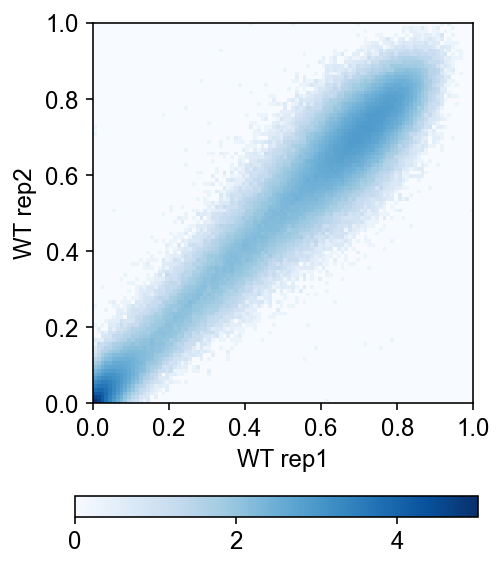

In [61]:
correlation_heatmap(
    merge_data['ratio_wt1'], merge_data['ratio_wt2'],
    x_bins=100, y_bins=100, 
    xlabel='WT rep1',
    ylabel='WT rep2',
    # title=f"Methylation comparison (CHG). R={r_coeff:.3f}"
    orientation='horizontal'
)

## CHG

In [9]:
infile = "/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/5mc_results/frequency/20221029_col_m6A.C.call_mods.frequency.CHG.bw"
wt1_chg_results = get_bin_coverage_turbo(infile, chrom_size, binsize=100)

In [10]:
infile = "/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/5mc_results/frequency/20221208_col_m6A.C.call_mods.frequency.CHG.bw"
wt2_chg_results = get_bin_coverage_turbo(infile, chrom_size, binsize=100)

In [47]:
wt1_chg_results = pd.DataFrame(wt1_chg_results, columns=['chrom', 'pos', 'ratio'])
wt2_chg_results = pd.DataFrame(wt2_chg_results, columns=['chrom', 'pos', 'ratio'])

In [62]:
merge_data = pd.merge(wt1_chg_results, wt2_chg_results, on=['chrom', 'pos'], suffixes=["_wt1", "_wt2"])

In [63]:
merge_data.dropna(inplace=True)

<Axes: xlabel='WT rep1', ylabel='WT rep2'>

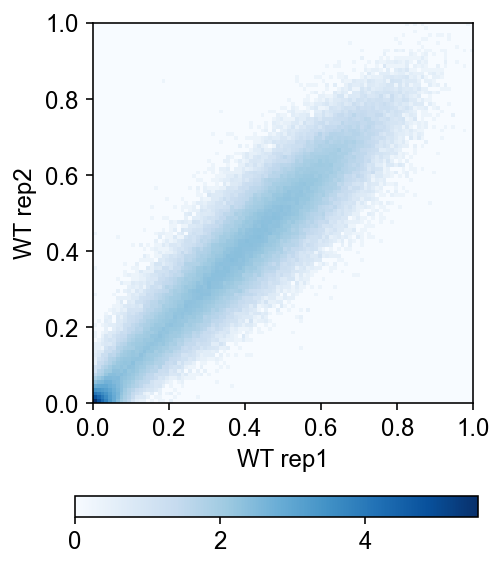

In [65]:
correlation_heatmap(
    merge_data['ratio_wt1'], merge_data['ratio_wt2'],
    x_bins=100, y_bins=100, 
    xlabel='WT rep1',
    ylabel='WT rep2',
    # title=f"Methylation comparison (CHG). R={r_coeff:.3f}"
    orientation='horizontal'
)

## CHH

In [11]:
infile = "/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/5mc_results/frequency/20221029_col_m6A.C.call_mods.frequency.CHH.bw"
wt1_chh_results = get_bin_coverage_turbo(infile, chrom_size, binsize=100)

In [12]:
infile = "/data/Zhaijx/mowp/data/stam_seq_col_CEN/test/5mc_results/frequency/20221208_col_m6A.C.call_mods.frequency.CHH.bw"
wt2_chh_results = get_bin_coverage_turbo(infile, chrom_size, binsize=100)

In [66]:
wt1_chh_results = pd.DataFrame(wt1_chh_results, columns=['chrom', 'pos', 'ratio'])
wt2_chh_results = pd.DataFrame(wt2_chh_results, columns=['chrom', 'pos', 'ratio'])

In [67]:
merge_data = pd.merge(wt1_chh_results, wt2_chh_results, on=['chrom', 'pos'], suffixes=["_wt1", "_wt2"])

In [69]:
stats.pearsonr(merge_data['ratio_wt1'], merge_data['ratio_wt2'])

(0.9321712991761625, 0.0)

<Axes: xlabel='WT rep1', ylabel='WT rep2'>

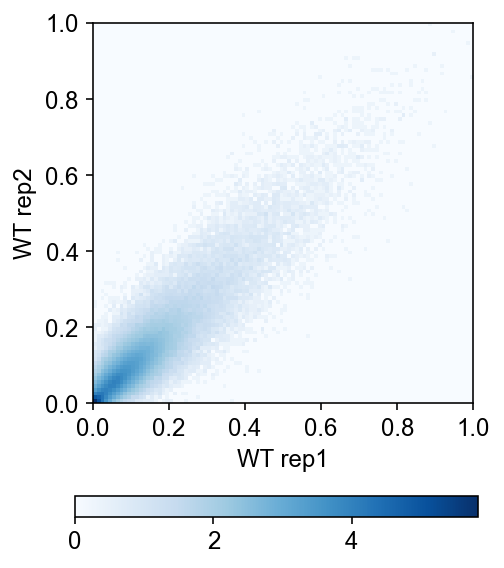

In [70]:
correlation_heatmap(
    merge_data['ratio_wt1'], merge_data['ratio_wt2'],
    x_bins=100, y_bins=100, 
    xlabel='WT rep1',
    ylabel='WT rep2',
    # title=f"Methylation comparison (CHG). R={r_coeff:.3f}"
    orientation='horizontal'
)

# STAM-seq vs WGBS

## CG

In [17]:
wt1_cg_results = pd.DataFrame(wt1_cg_results, columns=['chrom', 'pos', 'ratio'])
wgbs_cg_results = pd.DataFrame(wgbs_cg_results, columns=['chrom', 'pos', 'ratio'])

In [18]:
merge_data = pd.merge(wgbs_cg_results, wt1_cg_results, on=['chrom', 'pos'], suffixes=[".bis", ".stam"])

In [19]:
merge_data.dropna(inplace=True)

<Axes: xlabel='WGBS', ylabel='STAM-seq'>

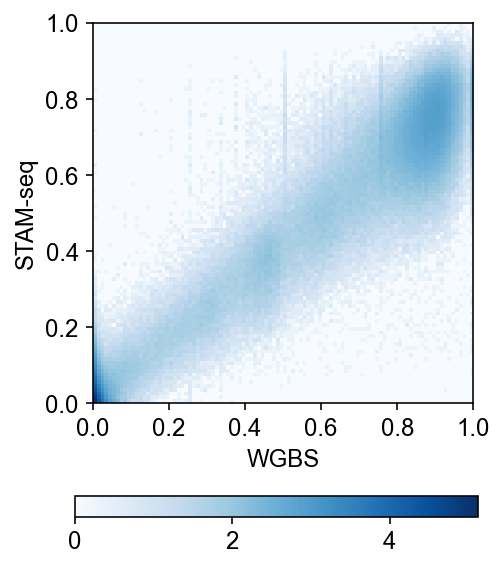

In [23]:
correlation_heatmap(
    merge_data['ratio.bis'], merge_data['ratio.stam'],
    x_bins=100, y_bins=100, 
    xlabel='WGBS',
    ylabel='STAM-seq',
    # title=f"Methylation comparison (CG). R={r_coeff:.3f}"
    orientation='horizontal'
)

## CHG

In [ ]:
wt1_chg_results = pd.DataFrame(wt1_chg_results, columns=['chrom', 'pos', 'ratio'])
wgbs_chg_results = pd.DataFrame(wgbs_chg_results, columns=['chrom', 'pos', 'ratio'])

In [34]:
merge_data = pd.merge(wgbs_chg_results, wt1_chg_results, on=['chrom', 'pos'], suffixes=[".bis", ".stam"])

In [36]:
r_coeff, pvalue = stats.pearsonr(merge_data['ratio.bis'], merge_data['ratio.stam'])
print(r_coeff, pvalue)

0.9698337063662549 0.0


<Axes: xlabel='WGBS', ylabel='STAM-seq'>

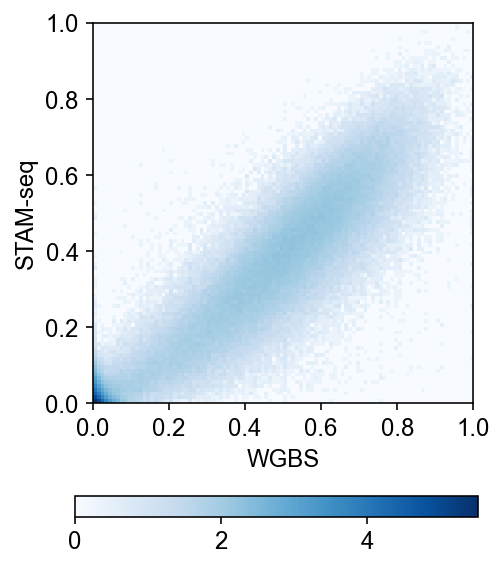

In [37]:
correlation_heatmap(
    merge_data['ratio.bis'], merge_data['ratio.stam'],
    x_bins=100, y_bins=100, 
    xlabel='WGBS',
    ylabel='STAM-seq',
    # title=f"Methylation comparison (CG). R={r_coeff:.3f}"
    orientation='horizontal'
)

## CHH

In [29]:
wt1_chh_results = pd.DataFrame(wt1_chh_results, columns=['chrom', 'pos', 'ratio'])
wgbs_chh_results = pd.DataFrame(wgbs_chh_results, columns=['chrom', 'pos', 'ratio'])

In [30]:
merge_data = pd.merge(wgbs_chh_results, wt1_chh_results, on=['chrom', 'pos'], suffixes=[".bis", ".stam"])

In [31]:
merge_data.dropna(inplace=True)

In [32]:
r_coeff, pvalue = stats.pearsonr(merge_data['ratio.bis'], merge_data['ratio.stam'])
print(r_coeff, pvalue)

0.8606029431125476 0.0


<Axes: xlabel='WGBS', ylabel='STAM-seq'>

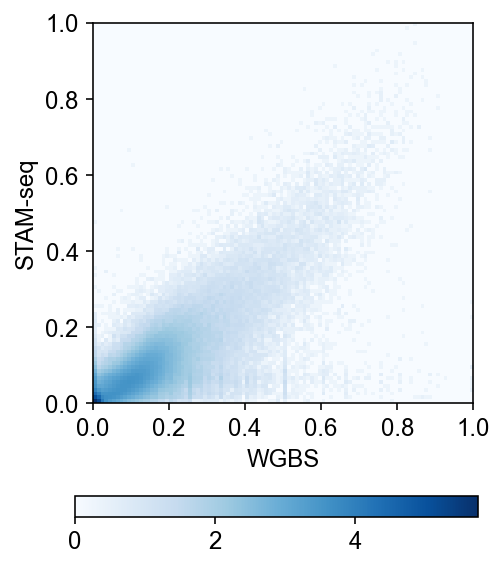

In [33]:
correlation_heatmap(
    merge_data['ratio.bis'], merge_data['ratio.stam'],
    x_bins=100, y_bins=100, 
    xlabel='WGBS',
    ylabel='STAM-seq',
    # title=f"Methylation comparison (CG). R={r_coeff:.3f}"
    orientation='horizontal'
)